# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Identifying-phenotypic-classes-in-transcriptomic-data" data-toc-modified-id="Identifying-phenotypic-classes-in-transcriptomic-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Identifying phenotypic classes in transcriptomic data</a></div><div class="lev1 toc-item"><a href="#Defining-the-phenotypic-classes" data-toc-modified-id="Defining-the-phenotypic-classes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Defining the phenotypic classes</a></div><div class="lev1 toc-item"><a href="#Distributions-of-effects-within-each-phenotypic-class-for-the-sy622-homozygote" data-toc-modified-id="Distributions-of-effects-within-each-phenotypic-class-for-the-sy622-homozygote-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Distributions of effects within each phenotypic class for the <em>sy622</em> homozygote</a></div><div class="lev2 toc-item"><a href="#Test-whether-the-medians-of-each-distribution-are-the-same." data-toc-modified-id="Test-whether-the-medians-of-each-distribution-are-the-same.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test whether the medians of each distribution are the same.</a></div><div class="lev2 toc-item"><a href="#Apply-the-bootstrap-to-each-pairwise-comparison" data-toc-modified-id="Apply-the-bootstrap-to-each-pairwise-comparison-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Apply the bootstrap to each pairwise comparison</a></div>

# Identifying phenotypic classes in transcriptomic data

In this notebook, I will put forward the concept of a phenotypic class, and I will show how to find these classes in this data. As always, the first step is to load in the libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numba 
from matplotlib import rc
import tissue_enrichment_analysis as ea

# import own libraries
import epistasis as epi
import pretty_table as pretty

# plotting settings
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# download the dataframe we will use:
tidy  = pd.read_csv('../input/quantifications.csv')

# set a parameter for statistical significance
q = 0.1

# Defining the phenotypic classes
The method by which I defined the phenotypic classes was outlined in the main manuscript, so I will not go into depth on how to do it here. Suffice to say that the molecular lesions strongly suggest a null hypothesis for how the sets should look, and false-positive and false-negative analyses suggest that the Venn diagram, and therefore the phenotypic classes, follow the expected null hypothesis. Here, I assign the transcripts to those classes suggested by the null hypothesis. As a first step, I find those genes that are differentially expressed in any combination of two genotypes.

In [13]:
# find all pairwise overlaps
overlap_sy622_het = epi.find_overlap(tidy, ['PS4087', 'PS4176'], q=q)
overlap_bx93_het = epi.find_overlap(tidy, ['PS4187', 'PS4176'], q=q)
overlap_sy622_bx93 = epi.find_overlap(tidy, ['PS4187', 'PS4087'], q=q)

Next, I use the same definitions as in the main text to combine (or exclude) genes from each pairwise overlap into phenotypic classes.

In [14]:
# The following code finds the desired transcripts (isoforms) in each class and puts them into numpy arrays:

def target(selection):
    return tidy.target_id.isin(selection)


sig = (tidy.qval < q)

sy622_associated = tidy[target(overlap_sy622_het) &
                        (~target(overlap_sy622_bx93))].target_id.unique()

bx93_associated = tidy[target(overlap_bx93_het) |
                       (target(overlap_sy622_bx93))].target_id.unique()

bx93_specific = tidy[(~target(overlap_sy622_bx93)) & 
                     (~target(overlap_bx93_het)) &
                      sig &
                     (tidy.strain == 'PS4187')].target_id.unique()

sy622_specific = tidy[(~target(overlap_sy622_bx93)) &
                      (~target(overlap_sy622_het)) &
                      sig &
                      (tidy.strain == 'PS4087')].target_id.unique()

transhet_specific = tidy[(~target(overlap_bx93_het)) &
                         (~target(overlap_sy622_het)) & 
                         sig &
                         (tidy.strain == 'PS4176')].target_id.unique()

Make a dictionary where each class is a key for its numpy array.

In [15]:
# Make a dictionary
classes = {'sy622 associated': sy622_associated,
           'bx93 associated': bx93_associated,
           'sy622 specific': sy622_specific,
           'bx93 specific': bx93_specific,
           'transhet specific': transhet_specific}

We also need the inverse dictionary, where each transcript is the key for its class. This will allow us to annotate the dataframe with a new column, phenotypic class. While we're at it, let's also print out how many transcripts exist in each phenotypic class.

In [16]:
inv_classes = {}

for key, value in classes.items():
    n = len(tidy[tidy.target_id.isin(value)].ens_gene.unique())
    print(key, n)
    
    for v in value:
        inv_classes[v] = key

sy622 associated 665
bx93 associated 229
sy622 specific 1213
bx93 specific 37
transhet specific 1302


Annotate the dataframe with the information on phenotypic classes, and save it to a file.

In [18]:
import pretty_table as pretty 

sig = (tidy.qval < q)
pretty.table_print(['Genotype', 'Strain', 'DEG'])
for genotype, group in tidy[sig].groupby('genotype'):
    # select the DE isoforms in the current genotype:
    strain = group.strain.unique()[0]
    deg = len(group.ens_gene.unique())
    pretty.table_print([genotype, strain, deg])

Genotype            Strain              DEG                 
bx93                PS4187              266                 
bx93/sy622          PS4176              2128                
ga80                EW15                4613                
n1046               MT2124              2526                
n2021               MT4866              509                 
sy622               PS4087              2036                


In [19]:
# label transcripts with the phenotypic class they belong to
tidy['phenotypic class'] = tidy.target_id.map(inv_classes)
# save to a dataframe
tidy.to_csv('../output/SI1_dpy_22_results.csv')

# Distributions of effects within each phenotypic class for the *sy622* homozygote

A quick check that we would like to run on these phenotypic classes is that they are not behaving like random sets. One method to check whether these distributions were randomly sampled from the set of all differentially expressed transcripts is to ask whether, **within a single genotype**, the transcripts in each class have the same distribution of effects. If they do have the same distributions, then they were probably sampled randomly. However, if the distributions are quite distinct, then we may be convinced they were not sampled in a manner consistent with random sampling. Let's check this by looking at the effect size of perturbations in the *sy622* homozygote, binning transcripts depending on which class they belong to.

Phenotypic Class    mean                median              0.95 quantile       
bx93 associated     1.3                 0.83                4.1                 
sy622 associated    1.1                 0.59                3.5                 
sy622 specific      0.97                0.55                3.4                 


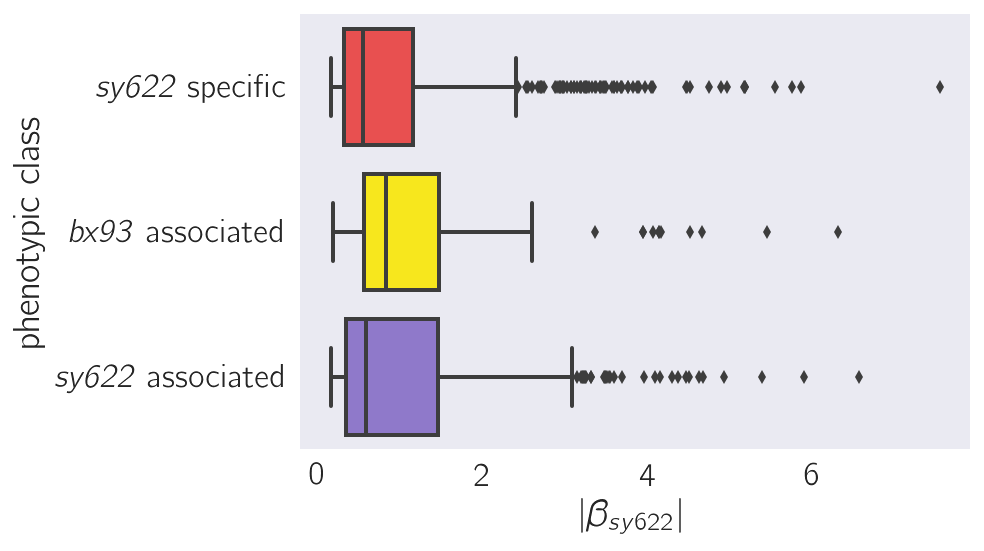

In [7]:
# select the desired values
temp = tidy[(tidy.qval < q) & (tidy.strain == 'PS4087')].dropna().copy()
# calculate the absolute magnitude of the effect size
temp.b = temp.b.abs()

# plot the distributions, binning by phenotypic class
sns.boxplot(y='phenotypic class', x='b', data=temp)

#prettify plot
plt.xlabel(r'$|\beta_{sy622}|$')

plt.gca().set_yticklabels([r'\emph{sy622} specific',
                           r'\emph{bx93} associated',
                           r'\emph{sy622} associated'])
plt.gca().artists[0].set_facecolor('#E85050')
plt.gca().artists[1].set_facecolor('#F7E71D')
plt.gca().artists[2].set_facecolor('#8F79CA')

# save
plt.savefig('../output/beta_values_phenotypic_classes_sy622.svg', bbox_inches='tight')

# print the relevant statistics to better understand the boxplots
grouped = temp.groupby('phenotypic class')
pretty.table_print(['Phenotypic Class', 'mean', 'median', '0.95 quantile'])

for name, group in grouped:
    # assemble the message to print
    L = "{0}\t{1:.2g}\t{2:.2g}\t{3:.2g}".format(name,
                                                group.b.mean(),
                                                np.median(group.b),
                                                group.b.quantile(.95)
                                               )
    l = L.split("\t")
    pretty.table_print(l)

## Test whether the medians of each distribution are the same.

We will do this by performing a non-parametric bootstrap, defined below.

In [8]:
def bootstrap_difference_of_statistic(x, y, n=10**4, statistic=np.mean):
    """
    Given two datasets, return a pvalue for null H (means are the same).
    
    Params:
    x, y - numpy arrays containing floats or ints
    n - number of bootstraps to perform
    statistic - a numbaizable function
    
    Output:
    delta - a numpy array containing the bootstraps
    """
    # necessary parameters
    nx = len(x)
    ny = len(y)
    mixed = np.zeros(nx + ny)
    mixed[0:nx] = x
    mixed[nx:] = y

    # numbaized bootstrap function for massive speed gains
    @numba.jit(nopython=True)
    def bootstrap(mixed, nx, ny, n):
        """
        Performs a non-parametric bootstrap for the test statistic, 
        statistic()
        '"""
        delta = np.zeros(n)
        for i in np.arange(n):
            nullx = np.random.choice(mixed, nx, replace=True)
            nully = np.random.choice(mixed, ny, replace=True)
            diff = statistic(nully) - statistic(nullx)
            delta[i] = diff
        return delta
    
    # perform the bootstrap and return the result
    delta = bootstrap(mixed, nx, ny, n)
    return delta

## Apply the bootstrap to each pairwise comparison

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


The p-value for this test is 0.018


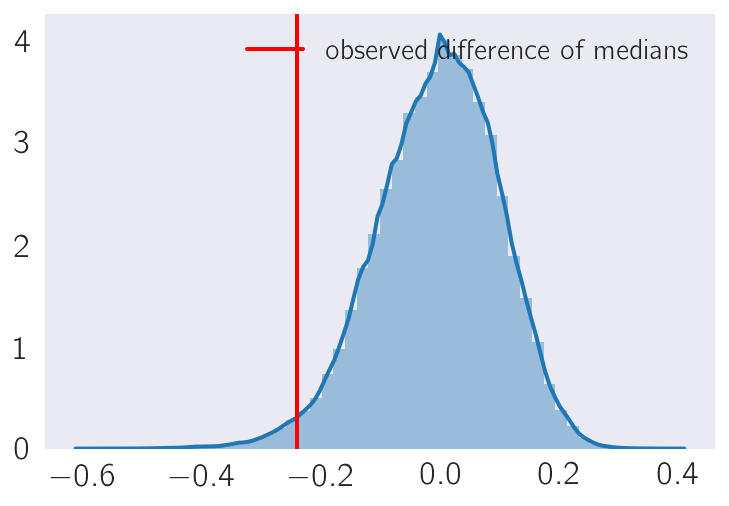

In [9]:
alpha = 10**-3  # statistical significance threshold
statistic = np.median  # statistic to use for testing

x = temp[temp['phenotypic class'] == 'bx93 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 associated'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=statistic)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red',
            label='observed difference of medians')
plt.legend()

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)

pretty.significance(pval, alpha, 'bx93 associated',
                    'sy622 associated', 'medians')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


bx93 associated and sy622 specific have statistically significantly different medians.
The p-value for this test is 0.0002


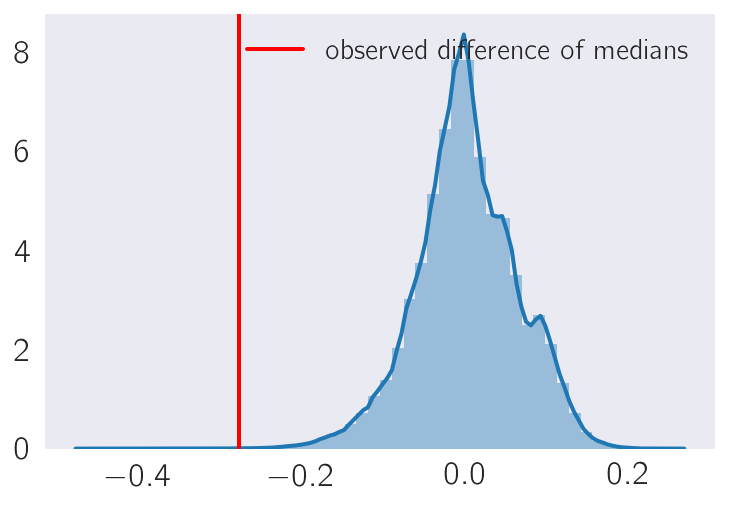

In [10]:
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=np.median)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red',
            label='observed difference of medians')
plt.legend()

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)
pretty.significance(pval, alpha, 'bx93 associated',
                    'sy622 specific', 'medians')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


The p-value for this test is 0.19


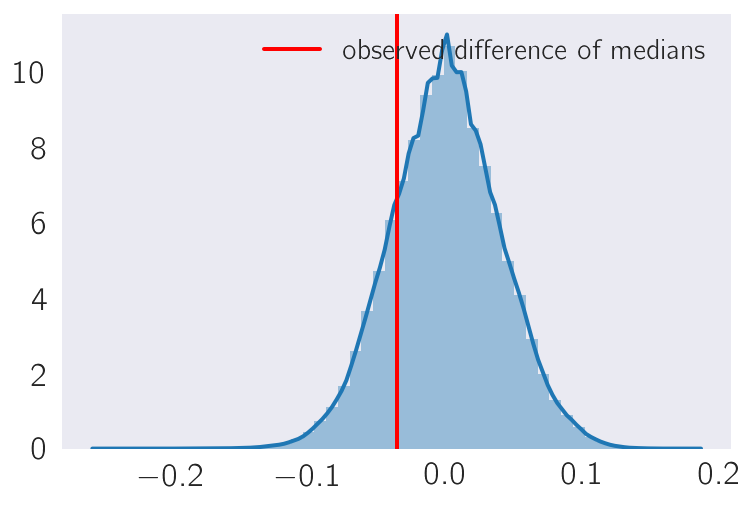

In [11]:
x = temp[temp['phenotypic class'] == 'sy622 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=np.median)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red',
            label='observed difference of medians')
plt.legend()

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)
pretty.significance(pval, alpha, 'sy622 associated',
                    'sy622 specific', 'medians')

2/3 possible comparisons reject the null hypothesis that the medians are the same. Therefore, these distributions do not appear to have been randomly sampled.